# Phase 2

# Tung-Yu Hsiao (tungyuh)
# Kaiyu Guan (kaiyug)

In [1]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
import pyspark
from pyspark import SparkContext, SQLContext 
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.sql.functions import lit
from functools import reduce

#### Initiating Spark Session

In [3]:
# Spark context access the hardware-level and software-leve configuration 
# For Spark 2.X
# Spark Session provides a unified interface for interacting with 
# different Spark APIs and allows applications to run on a Spark cluster. 

import pyspark
from pyspark import SparkContext, SQLContext 
from pyspark.sql import SparkSession

appName = "FIFA_project"

# Spark Session 
spark = SparkSession.builder.master("yarn").appName(appName).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/16 23:25:23 INFO SparkEnv: Registering MapOutputTracker
23/11/16 23:25:23 INFO SparkEnv: Registering BlockManagerMaster
23/11/16 23:25:23 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/11/16 23:25:23 INFO SparkEnv: Registering OutputCommitCoordinator


#### Ingesting Data into Spark DF

In [4]:
# Store data into one spark df
from pyspark.sql.functions import lit
from functools import reduce

path = "gs://dataproc-staging-us-east1-64370553033-nbuuz5pr/" # data on cloud path
file_paths = [path + "players_%d.csv" % n for n in range(15,23)]


# Read each CSV file and add a new column
dataframes = [spark.read.csv(file_path, header=True, inferSchema=True) for file_path in file_paths]


# Add a new column to each DataFrame
year = [str(n) for n in range(2015,2023)]
dataframes_with_column = [dataframes[i].withColumn("year", lit(year[i])) for i in range(len(dataframes))]

# Union all DataFrames
fifa = reduce(lambda df1, df2: df1.union(df2), dataframes_with_column)

# Add a unique primary key id column to dataframe
fifa = fifa.withColumn("id", monotonically_increasing_id())

# Show the final DataFrame
fifa.show(1, vertical = True)

23/11/16 23:26:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0-------------------------------------------
 sofifa_id                   | 158023               
 player_url                  | https://sofifa.co... 
 short_name                  | L. Messi             
 long_name                   | Lionel Andrés Mes... 
 player_positions            | CF                   
 overall                     | 93                   
 potential                   | 95                   
 value_eur                   | 1.005E8              
 wage_eur                    | 550000.0             
 age                         | 27                   
 dob                         | 1987-06-24 00:00:00  
 height_cm                   | 169                  
 weight_kg                   | 67                   
 club_team_id                | 241.0                
 club_name                   | FC Barcelona         
 league_name                 | Spain Primera Div... 
 league_level                | 1                    
 club_position               | CF             

In [5]:
# Check if all records are unique

print(fifa.distinct().count() == fifa.count())
fifa.count()

True


142079

In [6]:
# Schema
fifa.printSchema()

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: double (nullable = true)
 |-- wage_eur: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: timestamp (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: double (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: integer (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: timestamp (nullable = true)
 |-- club_contract_valid_until: integer (nullable = true)
 |-- nationality_id: integer (nullable

### Task 3 - Mechine Learning Modeling

In [7]:
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler, IndexToString
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import pandas as pd

In [8]:
# all comluns in fifa df
df = fifa
col_names = df.columns

Even though the columns are named in a nice format, our dataset has uninformative columns (`urls`) and repeated columns (e.g. `league_name` and `league_id`). Therefore, we chose to drop these columns are they may introduce bias to our prediction model. We then decide to drop columns that falls under the following categories:
- urls
- duplicated columns
- characteristic that does not contribute to the score of a player (e.g. race)

In [9]:
# Columns drop (dropping urls, duplicated columns, uninformative names, tags)
drop_cols = ["player_url", "short_name", "long_name", "league_name", "club_loaned_from", "player_face_url", "player_traits", "dob",
             "club_position", "player_tags", "club_logo_url", "club_flag_url", "nation_logo_url", "nation_flag_url", "player_positions", 
             "sofifa_id",  "club_jersey_number", "club_joined", "club_contract_valid_until", "nationality_id", "weak_foot", "id",
             "nation_jersey_number",  "nation_team_id", "real_face", "club_loaned_from", "nation_position", "preferred_foot", "club_team_id",
             "club_name", "body_type", "nationality_name", "work_rate"
]

There are also numeric columns that are stored as string. We are going to add/subtract the numbers stored in each cell then convert them to numeric.

In [10]:
sub_numeric = [
    "ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", "cam", "ram", "lm", "lcm", "cm", "rcm",
    "rm", "lwb", "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk"
]

In [11]:
# all nominal columns
nominal_cols = [
    "league_level", "year"
]

#### Date Cleaning

In [12]:
# casting columns from string to int
cast_col = ["release_clause_eur", "mentality_composure"]
df = df.withColumn("release_clause_eur", df["release_clause_eur"].cast("integer"))
df = df.withColumn("mentality_composure", df["mentality_composure"].cast("integer"))

# handle the sub_numeric columns before imputing
def combine_numbers(input_string):
    if "+" in input_string:
        numbers = input_string.split('+')
        result = int(numbers[0]) + int(numbers[1])
    elif "-" in input_string:
        numbers = input_string.split('-')
        result = int(numbers[0]) - int(numbers[1])
    else:
        result = int(input_string)
    return result

add_numbers_udf = udf(combine_numbers, IntegerType())

for col_name in sub_numeric:
    df = df.withColumn(col_name, add_numbers_udf(col_name))

df.show(1, vertical=True)

-RECORD 0-------------------------------------------
 sofifa_id                   | 158023               
 player_url                  | https://sofifa.co... 
 short_name                  | L. Messi             
 long_name                   | Lionel Andrés Mes... 
 player_positions            | CF                   
 overall                     | 93                   
 potential                   | 95                   
 value_eur                   | 1.005E8              
 wage_eur                    | 550000.0             
 age                         | 27                   
 dob                         | 1987-06-24 00:00:00  
 height_cm                   | 169                  
 weight_kg                   | 67                   
 club_team_id                | 241.0                
 club_name                   | FC Barcelona         
 league_name                 | Spain Primera Div... 
 league_level                | 1                    
 club_position               | CF             

In [13]:
# check for null after column dropping 
df_drop = df.drop(*drop_cols)
df_count_null = df_drop.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_drop.columns])

df_count_null.show(vertical=True)

-RECORD 0-----------------------------
 overall                     | 0      
 potential                   | 0      
 value_eur                   | 1897   
 wage_eur                    | 1622   
 age                         | 0      
 height_cm                   | 0      
 weight_kg                   | 0      
 league_level                | 2015   
 skill_moves                 | 0      
 international_reputation    | 0      
 release_clause_eur          | 55582  
 pace                        | 15791  
 shooting                    | 15791  
 passing                     | 15791  
 dribbling                   | 15791  
 defending                   | 15791  
 physic                      | 15791  
 attacking_crossing          | 0      
 attacking_finishing         | 0      
 attacking_heading_accuracy  | 0      
 attacking_short_passing     | 0      
 attacking_volleys           | 0      
 skill_dribbling             | 0      
 skill_curve                 | 0      
 skill_fk_accuracy       

The `goalkeeping_speed` columns is almost empty. After carefully examine the data stored in the `goalkeeping_speed` columns, we found that this columns only has value for goalkeepers. We then decide to drop this column as there are other important features that contributes to the overall score for a goal keeper. For the other columns, we decide to impute the missing value with the median of the columns.

The `league_level` columns is a nominal columns, we therefore also drop the rows with missing value in this column.

In [14]:
df_drop = df_drop.drop("goalkeeping_speed")
df_drop = df_drop.filter(df_drop.league_level.isNotNull())

For the other columns with null values, we decide to imputed it with the meidan of each column.

In [15]:
# imputation
columns_to_be_imputed = [
    "value_eur", "wage_eur", "pace", "shooting", "passing", "dribbling", 
    "defending", "physic", "release_clause_eur", "mentality_composure"
]
value_not_in_dataset = -200

# Replace None/Missing Value with a value that can't be present in the dataset.
df_with_filled_na = df_drop.fillna(-200, columns_to_be_imputed)

#Create new columns with imputed values. New columns will be suffixed with "_imputed"
imputer = Imputer (
            inputCols=columns_to_be_imputed,
            outputCols=["{}_imputed".format(c) for c in columns_to_be_imputed])\
            .setStrategy("median").setMissingValue(value_not_in_dataset)

df_imputed = imputer.fit(df_with_filled_na).transform(df_with_filled_na)
# we will drop the old column without imputation. We have only one column to be imputed

df_imputed_enhanced = df_imputed
for i in range(len(columns_to_be_imputed)):
    df_imputed_enhanced = df_imputed_enhanced.drop(columns_to_be_imputed[i])

# We will rename our newly imputed column with the correct name
df_imputed = df_imputed_enhanced
for col_names in columns_to_be_imputed:
    df_imputed = df_imputed.withColumnRenamed(f"{col_names}_imputed", f"{col_names}")

In [16]:
df_count_null_2 = df_imputed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_imputed.columns])
df_count_null_2.show(vertical=True)

-RECORD 0--------------------------
 overall                     | 0   
 potential                   | 0   
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 league_level                | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 attacking_crossing          | 0   
 attacking_finishing         | 0   
 attacking_heading_accuracy  | 0   
 attacking_short_passing     | 0   
 attacking_volleys           | 0   
 skill_dribbling             | 0   
 skill_curve                 | 0   
 skill_fk_accuracy           | 0   
 skill_long_passing          | 0   
 skill_ball_control          | 0   
 movement_acceleration       | 0   
 movement_sprint_speed       | 0   
 movement_agility            | 0   
 movement_reactions          | 0   
 movement_balance            | 0   
 power_shot_power            | 0   
 power_jumping               | 0   
 power_stamina               | 0   
 power_strength             

In [17]:
# numeric columns
numeric_col = list(np.setdiff1d(np.array(df_imputed.columns), np.array(nominal_cols)))

#### <center>For our code to run on the cloud, we have to omit the outlier handling process. </center>
#### <center>The three cell below are thus comment out. </center>

In [18]:
# # Handle outliers
# from functools import reduce

# def column_add(a,b):
#      return  a.__add__(b)
    
# def find_outliers(df):
#     # Identifying the numerical columns in a spark dataframe
#     numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

#     # Using the `for` loop to create new columns by identifying the outliers for each feature
#     for column in numeric_col:

#         less_Q1 = 'less_Q1_{}'.format(column)
#         more_Q3 = 'more_Q3_{}'.format(column)
#         Q1 = 'Q1_{}'.format(column)
#         Q3 = 'Q3_{}'.format(column)

#         # Q1 : First Quartile ., Q3 : Third Quartile
#         Q1 = df.approxQuantile(column,[0.25],relativeError=0)
#         Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
#         # IQR : Inter Quantile Range
#         # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
#         # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
#         IQR = Q3[0] - Q1[0]
        
#         #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
#         less_Q1 =  Q1[0] - 1.5*IQR
#         more_Q3 =  Q3[0] + 1.5*IQR
        
#         isOutlierCol = 'is_outlier_{}'.format(column)
        
#         df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

#     # Selecting the specific columns which we have added above, to check if there are any outliers
#     selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
#     # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
#     df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

#     # Dropping the extra columns created above, just to create nice dataframe., without extra columns
#     df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

#     return df

In [19]:
# df_with_outlier_handling = find_outliers(df_imputed)
# df_with_outlier_handling.groupby("total_outliers").count().sort("total_outliers", ascending=False).show()

In [20]:
# # remove rows with more than 25 outliers
# df_imputed_with_outliers_handled = df_with_outlier_handling.filter(df_with_outlier_handling['total_Outliers']<=25)

# # drop the total_outlier column since we no longer need it
# df_imputed_with_outliers_handled = df_imputed_with_outliers_handled.drop("total_Outliers")

In [21]:
# handle Correlation

# Find correlation
correlation_matrix = df_imputed[numeric_col].toPandas().corr()

# Set display options to show all columns and rows without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# NOT Print the correlation matrix
# correlation_matrix

In [22]:
# NOT Showing the sorted correlation
# correlation_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False)

Correlations are find between:
- `lam`, `cam`, `ram`, `cf`, `lf`, `rf`, `lm`, `rm`, `lw`, `rw`, `ls`, `rs`, `st`, `lcm`, `cm`, `rcm`, `skill_dribbling`, `skill_ball_control`,
- `lb`, `rb`, `lwb`, `rwb`, `ldm`, `cdm`, `rdm`, `cb`, `rcb`, `lcb`
- `lcb`, `rcb`, `cb`, `defending_sliding_tackle`, `defending_standing_tackle`, `defending_marking_awareness`, `mentality_interceptions`
- `goalkeeping_reflexes`, `gk`, `goalkeeping_diving`, `goalkeeping_positioning`, `goalkeeping_handling`, `goalkeeping_kicking`
- `attacking_short_passing`, `rcm`, `lcm`, `cm`,
- `mentality_positioning`, `cf`, `lf`, `rf`, `ls`, `rs`, `st`, `lw`, `rw`, `lam`, `cam`, `ram`,

- `movement_sprint_speed`, `movement_acceleration`

Therefore, we are dropping the following columns:
- `lam`, `cam`, `ram`, `cf`, `lf`, `rf`, `lm`, `rm`, `lw`, `rw`, `ls`, `rs`, `st`, `lcm`, `cm`, `rcm`, `skill_dribbling`, `lb`, `rb`, `lwb`, `rwb`, `ldm`, `cdm`, `rdm`, `rcb`, `lcb`, `defending_sliding_tackle`, `defending_standing_tackle`, `defending_marking_awareness`, `mentality_interceptions`, `goalkeeping_reflexes`, `goalkeeping_diving`, `goalkeeping_positioning`, `goalkeeping_handling`, `goalkeeping_kicking`, and `movement_acceleration`. 

In [23]:
# remove correlated columns
col_corr_drop = ['lam', 'cam', 'ram', 'cf', 'lf', 'rf', 'lm', 'rm', 'lw', 'rw', 'ls', 'rs', 'st', 'lcm', 'cm', 'rcm', 
                 'skill_dribbling', 'lb', 'rb', 'lwb', 'rwb', 'ldm', 'cdm', 'rdm', 'rcb', 'lcb', 'defending_sliding_tackle', 
                 'defending_standing_tackle', 'defending_marking_awareness', 'mentality_interceptions', 'goalkeeping_reflexes', 
                 'goalkeeping_diving', 'goalkeeping_positioning', 'goalkeeping_handling', 'goalkeeping_kicking', 'movement_acceleration']

df_cleaned = df_imputed.drop(*col_corr_drop)
new_numeric_col = list(np.setdiff1d(np.array(numeric_col), np.array(col_corr_drop)))
new_numeric_col.remove('overall')

# output column 
output_col = ["overall"]

new_correlation_matrix = df_cleaned[new_numeric_col].toPandas().corr()

# not show the correlation after handle
# new_correlation_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False)

In [24]:
# showing the dataset is cleaned
df_cleaned.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show(vertical=True)

-RECORD 0-------------------------
 overall                    | 0   
 potential                  | 0   
 age                        | 0   
 height_cm                  | 0   
 weight_kg                  | 0   
 league_level               | 0   
 skill_moves                | 0   
 international_reputation   | 0   
 attacking_crossing         | 0   
 attacking_finishing        | 0   
 attacking_heading_accuracy | 0   
 attacking_short_passing    | 0   
 attacking_volleys          | 0   
 skill_curve                | 0   
 skill_fk_accuracy          | 0   
 skill_long_passing         | 0   
 skill_ball_control         | 0   
 movement_sprint_speed      | 0   
 movement_agility           | 0   
 movement_reactions         | 0   
 movement_balance           | 0   
 power_shot_power           | 0   
 power_jumping              | 0   
 power_stamina              | 0   
 power_strength             | 0   
 power_long_shots           | 0   
 mentality_aggression       | 0   
 mentality_positioni

In [25]:
splits = df_cleaned.randomSplit([0.2, 0.8], 24)
df_cleaned = splits[0]

#### Data Pipeline

In [26]:
class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        dataset = dataset.withColumn("overall", col("overall").cast(LongType()))
        return dataset

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in new_numeric_col:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x + "_index" for x in nominal_cols]
    nominal_onehot_cols = [x + "_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = new_numeric_col + nominal_onehot_cols

    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols + nominal_id_cols + 
        nominal_onehot_cols + new_numeric_col + ['vectorized_features', 'id'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 

In [27]:
# get pipeline

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(df_cleaned)

# transform df 
df_pipe = preprocess_pipeline_model.transform(df_cleaned)
df_train, df_test = df_pipe.randomSplit([0.8, 0.2], seed=42)

In [28]:
df_pipe.select("features").show(1, truncate= False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                              

#### Models

#### Shallow Neural Network

In [29]:
# Convert to torch tensor
!pip install torch
import torch
import torch.nn as nn 
import torch.functional as F
from sklearn.model_selection import train_test_split
torch.manual_seed(42)

# X = np.array(df_trans.toPandas()["features"].values.tolist(), dtype=np.float32)
# y = np.array(df_trans.toPandas()["overall"].values.tolist(), dtype=np.float32)


XTrain = np.array(df_train.toPandas()["features"].values.tolist(), dtype=np.float32)
yTrain = np.array(df_train.toPandas()["overall"].values.tolist(), dtype=np.float32)
XTest = np.array(df_test.toPandas()["features"].values.tolist(), dtype=np.float32)
yTest = np.array(df_test.toPandas()["overall"].values.tolist(), dtype=np.float32)


In [30]:
# Validation-test split 

XTrain, XVal, yTrain, yVal = train_test_split(XTrain, yTrain, test_size=0.2, random_state=42)

XTrain = torch.tensor(XTrain, dtype=torch.float32)
yTrain = torch.tensor(yTrain, dtype=torch.float32).reshape(-1,1)

XVal = torch.tensor(XVal, dtype=torch.float32)
yVal = torch.tensor(yVal, dtype=torch.float32).reshape(-1,1)

XTest = torch.tensor(XTest, dtype=torch.float32)
yTest = torch.tensor(yTest, dtype=torch.float32).reshape(-1,1)


In [31]:
# Torch NN model import torch
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm 



class Model(nn.Module):
    def __init__(self, inputDim, outputDim, hiddenLayers=[128, 128]):
        super(Model, self).__init__()
        struc = []
        for i in range(len(hiddenLayers)+1):
            if i == 0:
                struc.append(nn.Linear(inputDim, hiddenLayers[0]))
                
            elif i == len(hiddenLayers):
                struc.append(nn.Linear(hiddenLayers[-1], outputDim))
                break 
            else:
                struc.append(nn.Linear(hiddenLayers[i-1], hiddenLayers[i]))
                
            struc.append(nn.ReLU())

        self.layer = nn.Sequential(*struc)

    def forward(self, x):
        return self.layer(x)
    

In [32]:
# Utilities
from sklearn.metrics import r2_score
class Train_Log:
    def __init__(self):

        self.ovrLoss = [] 
        self.batchLoss = []
        self.ovrValLoss = [] 

    def log_update_train(self, loss):

        self.batchLoss.append(loss)

    def log_update(self, trainLoss, validLoss):
        self.ovrLoss.append(trainLoss)
        self.ovrValLoss.append(validLoss)


def plotLoss(logger, epoch, bestEpoch, title=None):

    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    # plot loss for all batches
    ax[0].plot(logger.batchLoss, label= "Training Loss")
    ax[0].set_title("Batch Loss")
    ax[0].set_xlabel("Iterations")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    # plot loss of all epochs
    ax[1].plot(logger.ovrLoss, label = "Training Loss")
    ax[1].plot(logger.ovrValLoss, label = "Validation Loss")
    # if earlyStop:
    ax[1].axvline(x = bestEpoch , color="#F75D59", linewidth=0.8, linestyle="dashed", label="Early stop")
    ax[1].set_title("Training & Validation Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    
    if title:
        plt.suptitle(title)
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()
    # plt.savefig("Q3.png")

def plot_r2(prediction, label, title = None):
    r2 = r2_score(label, prediction)
    combined_array = np.concatenate([prediction, label])
    lb = np.min(combined_array)
    ub = np.max(combined_array)

    plt.scatter(label, prediction)
    plt.plot(np.arange(lb-10, ub+10), np.arange(lb-10, ub+10), "r--")
    plt.xlabel("Label")
    plt.ylabel("Prediction")

    plt.xlim((lb-5, ub+5))
    plt.ylim((lb-5, ub+5))
    plt.text((lb+ub)/2,(lb+ub)/2,"R2= %.2f" % r2, weight= "bold")
    if title:
        plt.title(title)
    plt.show()

In [33]:
# torch Dataset 
class Data(Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    
train = Data(XTrain, yTrain)
valid = Data(XVal, yVal)
# testLoader = Data(XTest, yTest)

In [34]:
# Training 

# Parameters
maxEpoch = 1000
batchSize = 1024
lr = 0.01
earlyStop = 20

In [35]:
import os
path = "./trained_models"

# check whether directory already exists
if not os.path.exists(path):
  os.mkdir(path)
  print("Folder %s created!" % path)
else:
  print("Folder %s already exists" % path)

Folder ./trained_models already exists


In [36]:
# Define Training Method 

def training(model, train, valid, maxEpoch = 1000
             , batchSize = 1024,lr = 0.001
             ,earlyStop = 20, plot_error = False, title=None):
    
    cur_early_stop = 0
    min_valid_loss = np.inf
    
    # Optimizer and Loss function 
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    lossFun = nn.MSELoss()


    trainLoader = DataLoader(train, batch_size=batchSize, shuffle= True)
    validLoader = DataLoader(valid, batch_size= batchSize, shuffle = True)
    # if lr_decay:
    #     torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay) # Decay learning rate

    # Train log
    logger = Train_Log()
    for epoch in range(maxEpoch):
        # loss, accuracy 
        train_loss,valid_loss = 0.0,0.0
        train_len, valid_len = len(trainLoader), len(validLoader)
        

        # Training
        with tqdm(trainLoader, unit="batch") as tepoch:
            for xBatch, Label in tepoch:
                tepoch.set_description("Epoch[{:2d}/{}] train".format(epoch+1, maxEpoch))
                # xBatch = xBatch.to(device)
                # Label = Label.to(device)
                out = model(xBatch)
                loss = lossFun(out, Label) 
                # reset grad
                optimizer.zero_grad()

                # backpropagation 
                loss.backward()

                # update
                optimizer.step()

                # train loss
                train_loss += (loss.item()/train_len)# average loss
                tepoch.set_postfix(train_loss=train_loss)

                logger.log_update_train(loss.item()) 

        # Validation 
        with torch.no_grad():
            with tqdm(validLoader, unit="batch") as tepoch:
                for xBatch, Label in tepoch:
                    tepoch.set_description("Epoch[{:2d}/{}] valid".format(epoch+1, maxEpoch))
                    # xBatch = xBatch.to(device)
                    # Label = Label.to(device)
                    out = model(xBatch)
                    loss = lossFun(out, Label)
                    
                    # validation loss of a batch (take mean of all iterations)
                    valid_loss += (loss.item()/valid_len)
                    tepoch.set_postfix(valid_loss=valid_loss)

        

        # update batch loss
        logger.log_update(train_loss, valid_loss)

            
        if min_valid_loss > valid_loss:
            print('Validation loss decreased({:9.6f}--->{:9.6f})...saving model'.format(min_valid_loss,valid_loss))
            
            cur_early_stop, min_valid_loss = 0, valid_loss     
            torch.save(model.state_dict(), path + "/current_best"+"_"+str(title)+".pth")
            best_model = model
            best_epoch = epoch
            
        # early stop if not improving 
        else:
            cur_early_stop += 1
            if cur_early_stop == earlyStop:
                print(f"\nNo improvment {earlyStop} consecutive epochs, early stopping.")
                break

    if plot_error:
        plotLoss(logger, epoch=epoch, bestEpoch=best_epoch, title = str(title))
        
    return best_model


Epoch[ 1/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 87.37batch/s, valid_loss=1.02e+3]


Validation loss decreased(      inf--->1019.832654)...saving model


Epoch[ 2/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 108.03batch/s, valid_loss=194]


Validation loss decreased(1019.832654--->194.401312)...saving model


Epoch[ 3/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 93.44batch/s, valid_loss=44.2]


Validation loss decreased(194.401312--->44.186245)...saving model


Epoch[ 4/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 79.15batch/s, valid_loss=23.1]


Validation loss decreased(44.186245--->23.149900)...saving model


Epoch[ 5/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 99.81batch/s, valid_loss=20.3]


Validation loss decreased(23.149900--->20.254272)...saving model


Epoch[ 6/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 83.89batch/s, valid_loss=19]


Validation loss decreased(20.254272--->19.013454)...saving model


Epoch[ 7/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 21.86batch/s, valid_loss=17.5]


Validation loss decreased(19.013454--->17.507838)...saving model


Epoch[ 8/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 86.35batch/s, valid_loss=16.5]


Validation loss decreased(17.507838--->16.541570)...saving model


Epoch[ 9/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 103.21batch/s, valid_loss=16]


Validation loss decreased(16.541570--->16.034432)...saving model


Epoch[10/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 76.02batch/s, valid_loss=15.2]


Validation loss decreased(16.034432--->15.201083)...saving model


Epoch[11/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 95.64batch/s, valid_loss=14.1]


Validation loss decreased(15.201083--->14.145221)...saving model


Epoch[12/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 86.21batch/s, valid_loss=13.6]


Validation loss decreased(14.145221--->13.628170)...saving model


Epoch[13/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 86.78batch/s, valid_loss=12.5]


Validation loss decreased(13.628170--->12.503612)...saving model


Epoch[14/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 95.99batch/s, valid_loss=12.2]


Validation loss decreased(12.503612--->12.158030)...saving model


Epoch[15/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 100.51batch/s, valid_loss=11.6]


Validation loss decreased(12.158030--->11.601081)...saving model


Epoch[16/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 101.82batch/s, valid_loss=11.1]


Validation loss decreased(11.601081--->11.145176)...saving model


Epoch[17/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 98.06batch/s, valid_loss=10.7]


Validation loss decreased(11.145176--->10.747809)...saving model


Epoch[18/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 79.78batch/s, valid_loss=10.3]


Validation loss decreased(10.747809--->10.295005)...saving model


Epoch[19/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 103.14batch/s, valid_loss=10.1]


Validation loss decreased(10.295005--->10.148155)...saving model


Epoch[20/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 81.50batch/s, valid_loss=10.1]


Validation loss decreased(10.148155--->10.088783)...saving model


Epoch[21/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 96.19batch/s, valid_loss=9.66]


Validation loss decreased(10.088783---> 9.664855)...saving model


Epoch[22/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 120.62batch/s, valid_loss=9.51]


Validation loss decreased( 9.664855---> 9.514593)...saving model


Epoch[23/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 82.06batch/s, valid_loss=9.45]


Validation loss decreased( 9.514593---> 9.450727)...saving model


Epoch[24/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 81.43batch/s, valid_loss=9.35]


Validation loss decreased( 9.450727---> 9.353229)...saving model


Epoch[25/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 65.74batch/s, valid_loss=9.14]


Validation loss decreased( 9.353229---> 9.135380)...saving model


Epoch[26/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 137.76batch/s, valid_loss=9.11]


Validation loss decreased( 9.135380---> 9.108576)...saving model


Epoch[27/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 104.14batch/s, valid_loss=8.99]


Validation loss decreased( 9.108576---> 8.992173)...saving model


Epoch[28/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 124.68batch/s, valid_loss=8.8]


Validation loss decreased( 8.992173---> 8.800585)...saving model


Epoch[31/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 77.21batch/s, valid_loss=8.75]


Validation loss decreased( 8.800585---> 8.754959)...saving model


Epoch[32/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 97.54batch/s, valid_loss=8.5]


Validation loss decreased( 8.754959---> 8.504208)...saving model


Epoch[34/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 78.23batch/s, valid_loss=8.48]


Validation loss decreased( 8.504208---> 8.480554)...saving model


Epoch[37/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 94.45batch/s, valid_loss=8.42]


Validation loss decreased( 8.480554---> 8.424558)...saving model


Epoch[38/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 89.10batch/s, valid_loss=8.29]


Validation loss decreased( 8.424558---> 8.291652)...saving model


Epoch[41/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 89.67batch/s, valid_loss=8.24]


Validation loss decreased( 8.291652---> 8.238886)...saving model


Epoch[42/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 83.29batch/s, valid_loss=8.21]


Validation loss decreased( 8.238886---> 8.213575)...saving model


Epoch[44/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 95.21batch/s, valid_loss=8.12]


Validation loss decreased( 8.213575---> 8.124356)...saving model


Epoch[45/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 101.22batch/s, valid_loss=8.12]


Validation loss decreased( 8.124356---> 8.120722)...saving model


Epoch[46/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 91.36batch/s, valid_loss=8.08]


Validation loss decreased( 8.120722---> 8.078682)...saving model


Epoch[48/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 93.47batch/s, valid_loss=7.94]


Validation loss decreased( 8.078682---> 7.937164)...saving model


Epoch[50/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 87.35batch/s, valid_loss=7.8]


Validation loss decreased( 7.937164---> 7.795277)...saving model


Epoch[52/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 55.93batch/s, valid_loss=7.79]


Validation loss decreased( 7.795277---> 7.790765)...saving model


Epoch[54/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 83.81batch/s, valid_loss=7.72]


Validation loss decreased( 7.790765---> 7.723529)...saving model


Epoch[55/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 79.97batch/s, valid_loss=7.59]


Validation loss decreased( 7.723529---> 7.587422)...saving model


Epoch[57/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 77.30batch/s, valid_loss=7.58]


Validation loss decreased( 7.587422---> 7.583980)...saving model


Epoch[59/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 79.90batch/s, valid_loss=7.53]


Validation loss decreased( 7.583980---> 7.531321)...saving model


Epoch[60/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 80.40batch/s, valid_loss=7.38]


Validation loss decreased( 7.531321---> 7.378008)...saving model


Epoch[138/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 42.30batch/s, valid_loss=4.44]]


Validation loss decreased( 4.559638---> 4.442710)...saving model


Epoch[139/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 43.63batch/s, valid_loss=4.43]


Validation loss decreased( 4.442710---> 4.433037)...saving model


Epoch[142/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 85.01batch/s, valid_loss=4.42]


Validation loss decreased( 4.433037---> 4.415056)...saving model


Epoch[143/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 61.68batch/s, valid_loss=4.33]


Validation loss decreased( 4.415056---> 4.333855)...saving model


Epoch[144/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 104.31batch/s, valid_loss=4.3]


Validation loss decreased( 4.333855---> 4.304130)...saving model


Epoch[147/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 64.60batch/s, valid_loss=4.29]


Validation loss decreased( 4.304130---> 4.288564)...saving model


Epoch[149/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 86.20batch/s, valid_loss=4.23]


Validation loss decreased( 4.288564---> 4.231716)...saving model


Epoch[150/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 70.63batch/s, valid_loss=4.23]


Validation loss decreased( 4.231716---> 4.226845)...saving model


Epoch[151/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 77.75batch/s, valid_loss=4.22]


Validation loss decreased( 4.226845---> 4.217776)...saving model


Epoch[153/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 77.78batch/s, valid_loss=4.17]


Validation loss decreased( 4.217776---> 4.173718)...saving model


Epoch[154/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 89.56batch/s, valid_loss=4.12]


Validation loss decreased( 4.173718---> 4.116791)...saving model


Epoch[158/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 77.82batch/s, valid_loss=4.08]


Validation loss decreased( 4.116791---> 4.075234)...saving model


Epoch[160/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 85.70batch/s, valid_loss=4.02]


Validation loss decreased( 4.075234---> 4.021088)...saving model


Epoch[162/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 77.05batch/s, valid_loss=4.02]


Validation loss decreased( 4.021088---> 4.019045)...saving model


Epoch[164/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 73.01batch/s, valid_loss=3.98]


Validation loss decreased( 4.019045---> 3.982701)...saving model


Epoch[291/1000] valid: 100%|██████████| 5/5 [00:00<00:00, 87.01batch/s, valid_loss=3.58]



No improvment 20 consecutive epochs, early stopping.


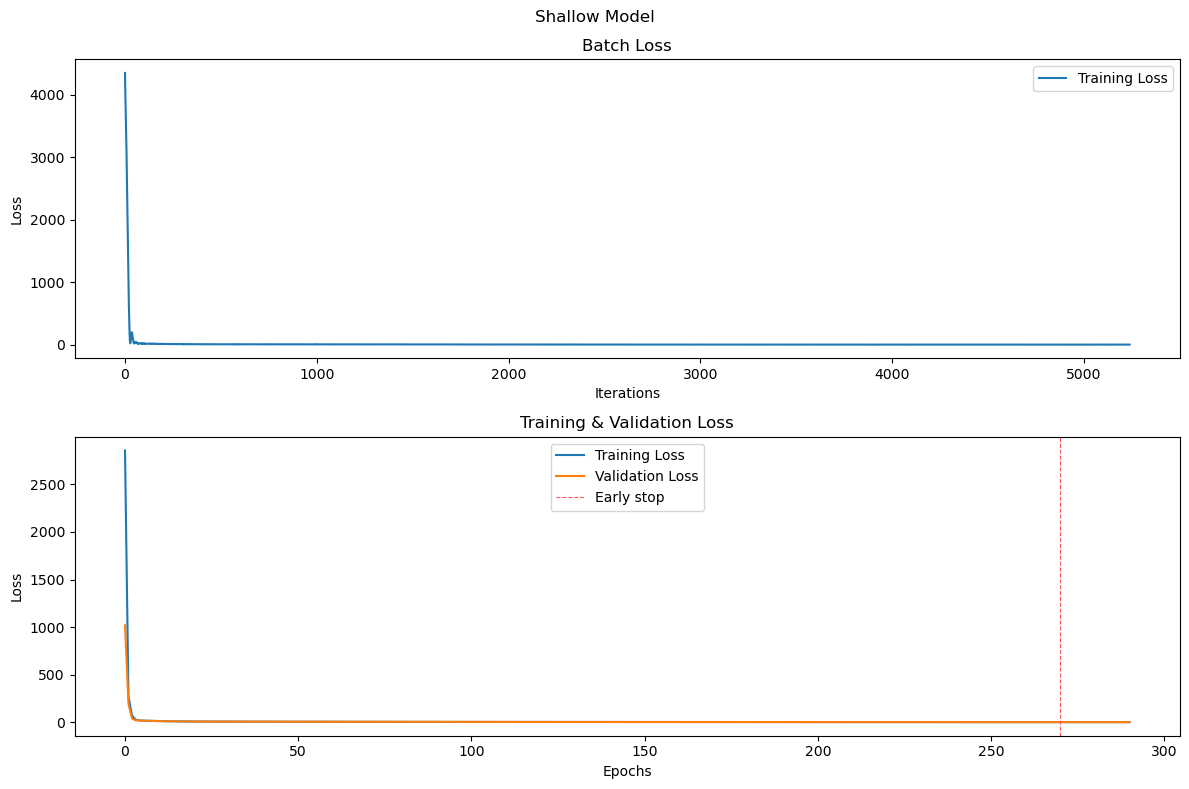

In [40]:
# Traning
# shallow model 
shallow = Model(inputDim=XTrain.shape[1], outputDim=1, hiddenLayers=[10])
shallow_trained = training(shallow, train, valid, maxEpoch=maxEpoch, batchSize = batchSize,
                           lr=lr, plot_error=True, title="Shallow Model")

In [41]:
pred_s = shallow_trained(XTest)

mse_s = nn.MSELoss()(pred_s, yTest)
print(f'The MSE for the best shallow nn model is {mse_s:.2f}.')

The MSE for the best shallow nn model is 3.52.


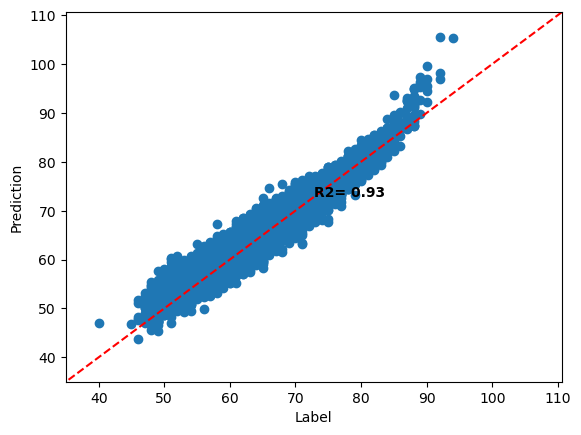

In [42]:
plot_r2(shallow_trained(XTrain).detach().numpy(), yTrain)